# Targeted Adversarial AI Attack Demo

#### Constants and Flags

In [21]:
import os

IMG_PATH = os.path.join(os.getcwd(), 'dataset/images/2153d9869fb5a9ef.png')

LABELS_PATH = os.path.join(os.getcwd(), 'dataset/ImageNet_labels.txt')
LABEL_DICT = eval(open(LABELS_PATH, 'r').read())

true_dict_keys = list(LABEL_DICT.keys())
true_dict_index_pos = list(LABEL_DICT.values()).index('matchstick')
TRUE_INDEX = true_dict_keys[true_dict_index_pos]

target_dict_keys = list(LABEL_DICT.keys())
target_dict_index_pos = list(LABEL_DICT.values()).index('goose')
TARGET_CLASS_INDEX = target_dict_keys[target_dict_index_pos]

print(TRUE_INDEX)
print(TARGET_CLASS_INDEX)

# ATTACK_TYPE = 'targeted_basic_iter'
ATTACK_TYPE = 'fgsm'
ATTACK_TYPE = 'targeted_fgsm'
ATTACK_TYPE = 'basic_iter'
ATTACK_TYPE = 'targeted_basic_iter'

644
99


In [4]:
LABEL_DICT

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark',
 5: 'electric ray, crampfish, numbfish, torpedo',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich, Struthio camelus',
 10: 'brambling, Fringilla montifringilla',
 11: 'goldfinch, Carduelis carduelis',
 12: 'house finch, linnet, Carpodacus mexicanus',
 13: 'junco, snowbird',
 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 15: 'robin, American robin, Turdus migratorius',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water ouzel, dipper',
 21: 'kite',
 22: 'bald eagle, American eagle, Haliaeetus leucocephalus',
 23: 'vulture',
 24: 'great grey owl, great gray owl, Strix nebulosa',
 25: 'European fire salamander, Salamandra salamandra',
 26: 'common newt, Triturus vulgaris',
 27: 'eft',
 28: 'spotted salamander, Ambystoma 

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import warnings
warnings.filterwarnings("ignore")

from cleverhans.attacks import FastGradientMethod, BasicIterativeMethod, SaliencyMapMethod
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim

from matplotlib.pyplot import imshow
%matplotlib inline

tf.flags.DEFINE_string(
    'master', '', 'The address of the TensorFlow master to use.')

tf.flags.DEFINE_string(
    'checkpoint_path', './dataset/inception_v3.ckpt', 'Path to checkpoint for inception network.')

tf.flags.DEFINE_string(
    'input_dir', './data/dev_images', 'Input directory with images.')

tf.flags.DEFINE_string(
    'output_dir', './output/images', 'Output directory with images.')

tf.flags.DEFINE_float(
    'max_epsilon', 16.0, 'Maximum size of adversarial perturbation.')

tf.flags.DEFINE_integer(
    'image_width', 299, 'Width of each input images.')

tf.flags.DEFINE_integer(
    'image_height', 299, 'Height of each input images.')

tf.flags.DEFINE_integer(
    'batch_size', 1, 'How many images process at one time.')

tf.logging.set_verbosity(tf.logging.INFO)

FLAGS = tf.flags.FLAGS

BATCH_SHAPE = [FLAGS.batch_size, FLAGS.image_height, FLAGS.image_width, 3]
NUM_CLASSES = 1001

# Images for inception classifier are normalized to be in [-1, 1] interval,
# eps is a difference between pixels so it should be in [0, 2] interval.
# Renormalizing epsilon from [0, 255] to [0, 2].
EPSILON = 2.0 * FLAGS.max_epsilon / 255.0

#### Utility Functions

In [6]:
def load_image(image_path, batch_shape):
    """Read png images from input directory in batches.

    Args:
        image_path: path to image file (png)
        batch_shape: shape of minibatch array, i.e. [batch_size, height, width, 3]

    Yields:
        filenames: list file names without path of each image
            Length of this list could be less than batch_size, in this case only
            first few images of the result are elements of the minibatch.
        images: array with all images from this batch
    """
    images = np.zeros(batch_shape)
    filenames = []
    batch_size = batch_shape[0]
    with tf.gfile.Open(image_path) as f:
        image = np.array(Image.open(f).convert('RGB')).astype(np.float) / 255.0 # [0,1]
    # Images for inception classifier are normalized to be in [-1, 1] interval.
    images[0, :, :, :] = image * 2.0 - 1.0
    filenames.append(os.path.basename(image_path))
    yield filenames, images

In [7]:
def show_images(imgs):
    # Images for inception classifier are normalized to be in [-1, 1] interval,
    # so rescale them back to [0, 1].
    img = (((imgs[0, :, :, :] + 1.0) * 0.5) * 255.0).astype(np.uint8)
    imshow(img)

#### Define Defence Model

In [8]:
class InceptionModel(object):
    """Model class for CleverHans library."""

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.built = False

    def __call__(self, x_input):
        """Constructs model and return probabilities for given input."""
        reuse = True if self.built else None
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            _, end_points = inception.inception_v3(
                    x_input, num_classes=self.num_classes, is_training=False,
                    reuse=reuse)
        self.built = True
        output = end_points['Predictions']
        # Strip off the extra reshape op at the output
        probs = output.op.inputs[0]
        return probs
    
INCEPTION_MODEL = InceptionModel(NUM_CLASSES)

#### Setup Defence Model

In [9]:
# Prepare defence graph
defence_graph = tf.Graph()
with defence_graph.as_default():
    defence_x_input = tf.placeholder(tf.float32, shape=BATCH_SHAPE)

    with slim.arg_scope(inception.inception_v3_arg_scope()):
        _, end_points = inception.inception_v3(
                defence_x_input, num_classes=NUM_CLASSES, is_training=False)

        # Restore the checkpoint
        defence_sess = tf.Session(graph=defence_graph)
        saver = tf.train.Saver()
        saver.restore(defence_sess, FLAGS.checkpoint_path)
        
    defence_predicted_labels = tf.nn.top_k(end_points['Predictions'], k=5, sorted=True, name=None)

    # Construct the scalar neuron tensor
    logits = defence_graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
    neuron_selector = tf.placeholder(tf.int32)
    y = logits[0][neuron_selector]

    # Construct tensor for predictions
    prediction = tf.argmax(logits, 1)
    
    # Prepare computation
#     defence_saver = tf.train.Saver(slim.get_model_variables())
#     defence_session_creator = tf.train.ChiefSessionCreator(
#             scaffold=tf.train.Scaffold(saver=defence_saver),
#             checkpoint_filename_with_path=FLAGS.checkpoint_path,
#             master=FLAGS.master)

#     defence_sess = tf.train.MonitoredSession(session_creator=defence_session_creator)

INFO:tensorflow:Restoring parameters from ./dataset/inception_v3.ckpt


#### Setup Adversarial Attack

In [10]:
# Prepare attack graph
adv_graph = tf.Graph()
with adv_graph.as_default():
    adv_x_input = tf.placeholder(tf.float32, shape=BATCH_SHAPE)
    
    if ATTACK_TYPE == 'fgsm':
        fgsm = FastGradientMethod(INCEPTION_MODEL)
        x_adv = fgsm.generate(adv_x_input, eps=EPSILON, clip_min=-1., clip_max=1.)
        
    if ATTACK_TYPE == 'targeted_fgsm':
        fgsm = FastGradientMethod(INCEPTION_MODEL)
        eps_iter = 2.0 * 1 / 255.0
        one_hot_target = np.zeros((1, NUM_CLASSES), dtype=np.float32)
        one_hot_target[0, TARGET_CLASS_INDEX] = 1
        x_adv = fgsm.generate(adv_x_input, eps=EPSILON, eps_iter=eps_iter, nb_iter=10, 
                             clip_min=-1., clip_max=1., y_target=one_hot_target)
#         x_adv = fgsm.generate(adv_x_input, eps=EPSILON, clip_min=-1., clip_max=1.)
        
    elif ATTACK_TYPE == 'basic_iter':
        bim = BasicIterativeMethod(INCEPTION_MODEL)
        eps_iter = 2.0 * 1 / 255.0
        x_adv = bim.generate(adv_x_input, eps=EPSILON, eps_iter=eps_iter, nb_iter=10, 
                             clip_min=-1., clip_max=1.)
        
    elif ATTACK_TYPE == 'targeted_basic_iter':
        bim = BasicIterativeMethod(INCEPTION_MODEL)
        eps_iter = 2.0 * 1 / 255.0
#         eps_iter = 2.0 * 1 / 255.0
#         For infinity norm alpha = epsilon / num steps
#         eps_iter = EPSILON / 10
        one_hot_target = np.zeros((1, NUM_CLASSES), dtype=np.float32)
        one_hot_target[0, TARGET_CLASS_INDEX] = 1
        x_adv = bim.generate(adv_x_input, eps=EPSILON, eps_iter=eps_iter, nb_iter=10, 
                             clip_min=-1., clip_max=1., y_target=one_hot_target)

    # Prepare computation
    adv_saver = tf.train.Saver(slim.get_model_variables())
    adv_session_creator = tf.train.ChiefSessionCreator(
            scaffold=tf.train.Scaffold(saver=adv_saver),
            checkpoint_filename_with_path=FLAGS.checkpoint_path,
            master=FLAGS.master)

    adv_sess = tf.train.MonitoredSession(session_creator=adv_session_creator)

INFO:tensorflow:Restoring parameters from ./dataset/inception_v3.ckpt


## ATTACK

### Classify Original Image

In [11]:
TARGET_CLASS_INDEX, LABEL_DICT[TARGET_CLASS_INDEX]

(99, 'goose')

Querying defence model...

Original Top-5 Predictions
1: matchstick 0.980402
2: candle, taper, wax light 0.00669314
3: lighter, light, igniter, ignitor 0.00145695
4: torch 0.000500239
5: black swan, Cygnus atratus 0.000113105


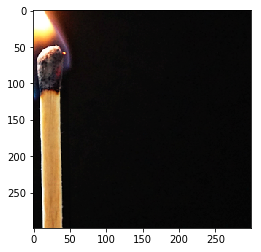

In [12]:
for filenames, images in load_image(IMG_PATH, BATCH_SHAPE):
    print('Querying defence model...\n')
    labels = defence_sess.run(defence_predicted_labels, feed_dict={defence_x_input: images})
    show_images(images)
    
accuracies_original, label_indices_original = list(labels[0][0]), list(labels[1][0])
print('Original Top-5 Predictions')
for i in range(len(accuracies_original)):
    print("{0}:".format(i+1), LABEL_DICT[label_indices_original[i] - 1], accuracies_original[i])

### Classify Adversarial Image

Generating adversarial image...
Attacking defence model...

Adversarial Top-5 Predictions
1: goose 0.995282
2: green mamba 0.000281978
3: red-breasted merganser, Mergus serrator 0.000129468
4: bustard 0.000120455
5: marmoset 0.000106914


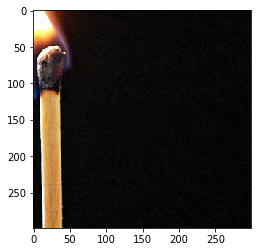

In [13]:
for filenames, images in load_image(IMG_PATH, BATCH_SHAPE):
    print('Generating adversarial image...')
    adv_images = adv_sess.run(x_adv, feed_dict={adv_x_input: images})
    show_images(adv_images)
    ADV_IMAGE = adv_images[0]
    print('Attacking defence model...\n')
    adv_labels = defence_sess.run(defence_predicted_labels, feed_dict={defence_x_input: adv_images})
    
accuracies, label_indices = list(adv_labels[0][0]), list(adv_labels[1][0])
print('Adversarial Top-5 Predictions')
for i in range(len(accuracies)):
    # Attack model 
    print("{0}:".format(i+1), LABEL_DICT[label_indices[i]], accuracies[i])

## DEFENCE

### Gaussian Smooth Adversarial Images

In [14]:
from scipy.ndimage import gaussian_filter

Generating adversarial image...
Smoothing adversarial image...
Attacking defence model...

Adversarial Top-5 Predictions after Gaussian Filter
1: matchstick 0.579213
2: candle, taper, wax light 0.0255777
3: stinkhorn, carrion fungus 0.0160474
4: black swan, Cygnus atratus 0.01572
5: red-breasted merganser, Mergus serrator 0.00748083


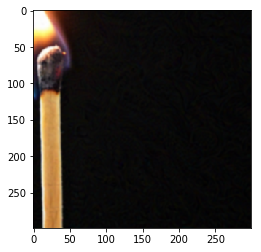

In [15]:
for filenames, images in load_image(IMG_PATH, BATCH_SHAPE):

    print('Generating adversarial image...')
    adv_images = adv_sess.run(x_adv, feed_dict={adv_x_input: images})
    
    # gaussian filter to smooth image
    print('Smoothing adversarial image...')
    filt_images = np.zeros(BATCH_SHAPE)
    filt_images[0] = gaussian_filter(adv_images[0], sigma=(1, 1, 0), order=0)
    
    show_images(filt_images)
    FILT_IMAGE = filt_images[0]
    print('Attacking defence model...\n')
    filt_labels = defence_sess.run(defence_predicted_labels, feed_dict={defence_x_input: filt_images})


filt_accuracies, filt_label_indices = list(filt_labels[0][0]), list(filt_labels[1][0])
print('Adversarial Top-5 Predictions after Gaussian Filter')
for i in range(len(filt_accuracies)):
    # Attack model 
    print("{0}:".format(i+1), LABEL_DICT[filt_label_indices[i] - 1], filt_accuracies[i])

## VISUALIZE GRAD-CAM

In [16]:
import matplotlib.pyplot as plt
import saliency
from saliency import SaliencyMask

class GradCam(SaliencyMask):
    """A SaliencyMask class that computes saliency masks with Grad-CAM.
  
    https://arxiv.org/abs/1610.02391

    Example usage (based on Examples.ipynb):

    grad_cam = GradCam(graph, sess, y, images, conv_layer = end_points['Mixed_7c'])
    grad_mask_2d = grad_cam.GetMask(im, feed_dict = {neuron_selector: prediction_class}, 
                                    should_resize = False, 
                                    three_dims = False)

    The Grad-CAM paper suggests using the last convolutional layer, which would 
    be 'Mixed_5c' in inception_v2 and 'Mixed_7c' in inception_v3.

    """
    def __init__(self, graph, session, y, x, conv_layer):
        super(GradCam, self).__init__(graph, session, y, x)
        self.conv_layer = conv_layer
        self.gradients_node = tf.gradients(y, conv_layer)[0]

    def GetMask(self, x_value, feed_dict={}, should_resize = True, three_dims = True):
        """
        Returns a Grad-CAM mask.
        
        Modified from https://github.com/Ankush96/grad-cam.tensorflow/blob/master/main.py#L29-L62

        Args:
          x_value: Input value, not batched.
          feed_dict: (Optional) feed dictionary to pass to the session.run call.
          should_resize: boolean that determines whether a low-res Grad-CAM mask should be 
              upsampled to match the size of the input image
          three_dims: boolean that determines whether the grayscale mask should be converted
              into a 3D mask by copying the 2D mask value's into each color channel
            
        """
        feed_dict[self.x] = [x_value]
        (output, grad) = self.session.run([self.conv_layer, self.gradients_node], 
                                               feed_dict=feed_dict)
        output = output[0]
        grad = grad[0]

        weights = np.mean(grad, axis=(0,1))
        grad_cam = np.ones(output.shape[0:2], dtype=np.float32)

        # weighted average
        for i, w in enumerate(weights):
            grad_cam += w * output[:, :, i]

        # pass through relu
        grad_cam = np.maximum(grad_cam, 0)

        # resize heatmap to be the same size as the input
        if should_resize:
            grad_cam = grad_cam / np.max(grad_cam) # values need to be [0,1] to be resized
            with self.graph.as_default():
                grad_cam = np.squeeze(tf.image.resize_bilinear(
                    np.expand_dims(np.expand_dims(grad_cam, 0), 3), 
                    x_value.shape[:2]).eval(session=self.session))

        # convert grayscale to 3-D
        if three_dims:
            grad_cam = np.expand_dims(grad_cam, axis=2)
            grad_cam = np.tile(grad_cam,[1,1,3])

        return grad_cam
    
def create_grad_cam_viz(img, label_index):
    grad_mask = grad_cam.GetMask(img, feed_dict={neuron_selector: label_index},
                                 should_resize=True, three_dims=True)
    grad_mask = saliency.VisualizeImageGrayscale(grad_mask)
    rgba_img = cmap(grad_mask)
    rgb_img = np.delete(rgba_img, 3, 2)
    return rgb_img

In [17]:
def process_img(img):
    '''For scaling back images to visualize gradients'''
    img = img - np.min(img)
    img = (img / np.max(img) * 255.).astype(np.uint8)
    return img

def overlay(array1, array2, alpha=0.5):
    """Overlays `array1` onto `array2` with `alpha` blending.
    Args:
        array1: The first numpy array.
        array2: The second numpy array.
        alpha: The alpha value of `array1` as overlayed onto `array2`. This value needs to be between [0, 1],
            with 0 being `array2` only to 1 being `array1` only (Default value = 0.5).
    Returns:
        The `array1`, overlayed with `array2` using `alpha` blending.
    """
    if alpha < 0. or alpha > 1.:
        raise ValueError("`alpha` needs to be between [0, 1]")
    if array1.shape != array2.shape:
        raise ValueError('`array1` and `array2` must have the same shapes')

    return (array1 * alpha + array2 * (1. - alpha)).astype(array1.dtype)

In [18]:
cmap = plt.get_cmap('jet')
grad_cam = GradCam(defence_graph, defence_sess, y, defence_x_input, conv_layer=end_points['Mixed_7c'])

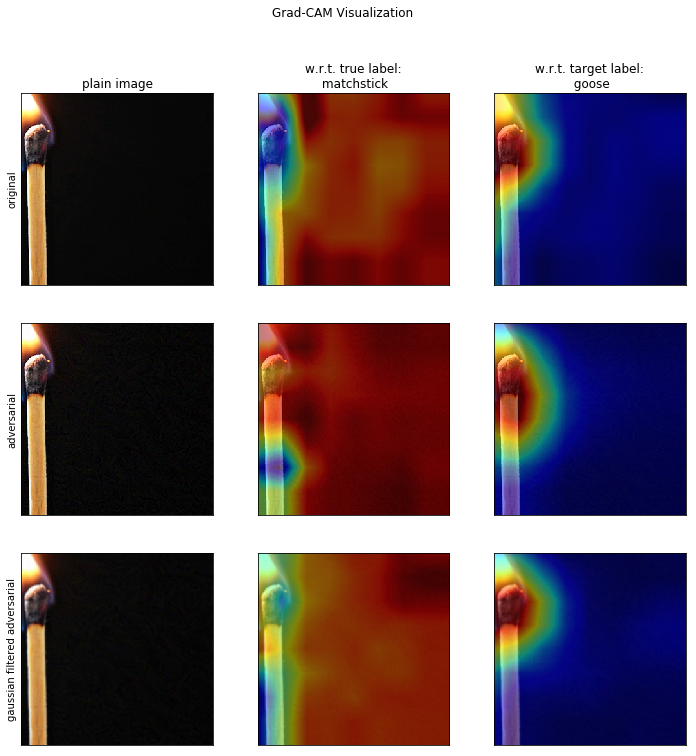

In [19]:
f, ax = plt.subplots(3,3, figsize=(12,12))

# original image
ax[0,0].imshow(process_img(images[0]))
ax[0,1].imshow(overlay(process_img(create_grad_cam_viz(images[0], TRUE_INDEX)), 
                       process_img(images[0])))
ax[0,2].imshow(overlay(process_img(create_grad_cam_viz(images[0], TARGET_CLASS_INDEX)), 
                       process_img(images[0])))

# adversarial image
ax[1,0].imshow(process_img(adv_images[0]))
ax[1,1].imshow(overlay(process_img(create_grad_cam_viz(adv_images[0], TRUE_INDEX)), 
                       process_img(adv_images[0])))
ax[1,2].imshow(overlay(process_img(create_grad_cam_viz(adv_images[0], TARGET_CLASS_INDEX)), 
                       process_img(adv_images[0])))

# gaussian filtered adversarial image
ax[2,0].imshow(process_img(filt_images[0]))
ax[2,1].imshow(overlay(process_img(create_grad_cam_viz(filt_images[0], TRUE_INDEX)), 
                       process_img(filt_images[0])))
ax[2,2].imshow(overlay(process_img(create_grad_cam_viz(filt_images[0], TARGET_CLASS_INDEX)), 
                       process_img(filt_images[0])))


ax[0,0].set_ylabel("original")
ax[1,0].set_ylabel("adversarial")
ax[2,0].set_ylabel("gaussian filtered adversarial")

ax[0,0].set_title("plain image")
ax[0,1].set_title("w.r.t. true label:\n {0}".format(LABEL_DICT[TRUE_INDEX]))
ax[0,2].set_title("w.r.t. target label:\n {0}".format(LABEL_DICT[TARGET_CLASS_INDEX]))

for i in range(3):
    for j in range(3):
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

plt.suptitle("Grad-CAM Visualization");

# plt.savefig("sample_output/heatmap_{0}_to_{1}.png".format("_".join(LABEL_DICT[TRUE_INDEX].split()),
#                                                           "_".join(LABEL_DICT[TARGET_CLASS_INDEX].split())))